# The Parks-McClellan Filter Design Method

The Parks-McClellan (PM) algorithm is a clever application of advanced polynomial fitting techniques to the problem of FIR filter design. In this notebook we will explore the key ideas behind the method by considering the design of a simple Type-I lowpass filter.

In [1]:
# standard bookkeeping
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from ipywidgets import interactive, fixed
plt.rcParams["figure.figsize"] = (14,4)

The first intuition is to recognize that finding the filter's coefficients is equivalent to solving a polynomial fitting problem. Since we want a linear-phase filter, the filter will be symmetric and we can easily show that in this case its frequency response is the real-valued function:

$$
    H(e^{j\omega}) = h[0] + \sum_{n = 1}^{M} 2h[n]\cos n\omega
$$

In the above expression, the $N = 2M+1$ nonzero taps of the impulse response $h[n]$ are $h[-M]$ to $h[M]$. Given a (positive) passband $[0, \omega_p]$ and a stopband $[\omega_s, \pi]$, we need to fit $H(e^{j\omega})$ to one in the passband and zero in the stopband as in the following figure. 

<img src="specs.png" alt="Drawing" style="width: 600px;"/>

Enter [Chebishev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials) (CP): they have a ton of interesting properties but the relevant one here is that $T_n(\cos\omega) = \cos n\omega$, where $T_n(x)$ is the CP of order $n$. Since the coefficients for the CP are easy to determine, with a simple substitution we can write:

$$
   H(e^{j\omega}) =  \sum_{n = 0}^{M}p_n x^n \qquad \mbox{with $x = \cos\omega$}
$$

While the relation between the $M+1$ $p_n$ coefficients and the $2M+1$ filter coefficients is nonlinear, it is easily invertible and therefore we can just concentrate on fitting the degree-$M$ polynomial over the desired response.

For the sake of simplicity, let's skip some of the details associated to the Chebishev substitution (for instance, the mapping $x=\cos\omega$ reverses the abscissae) and let's examine the following equivalent problem:

> consider the desired function: $$ D(x) = \begin{cases} 1 & \mbox{for $x\in [0, A]$} \\ 0 & \mbox{for $x\in [B,1]$} \end{cases}$$ <br> find the coefficients of a degree-$M$ polynomial $P(x)$ so that $P(x)\approx D(x)$ over $[0,A]\cup [B,1]$

## Standard polynomial fitting

The simplest approach is to use standard polynomial fitting: choose $a$ points in $[0, A]$ and $b$ points in $[B, 1]$ so that $a+b = M+1$ and find an interpolator over the coordinate pairs:

$$
  (x_0, 1), (x_1, 1), \ldots, (x_{a-1}, 1), (x_a, 0), (x_{a+1}, 0), \ldots, (x_{a+b-1}, 0)
$$

The result will minimize the mean square error between the interpolator and the piecewise characteristic we are trying to approximate. 

We can write a simple Python function to test this approach; you can play with the sliders below and see the result of the plain interpolation as the order and the size of the intervals change:

In [2]:
def MSE_fit(A, B, order):
    if order < 3:
        raise ValueError("order is too small, we need at least 3")
    
    # interpolation points always one more than the order of the interpolator
    pts = order+1
    # split number of interpolation points across intervals proportionately 
    #  with the length of each interval 
    ptsA = int(pts * A / (A+(1-B)))
    if ptsA < 2:
        ptsA = 2
    ptsB = pts - ptsA
    
    # for the MSE fit, place a point at each interval edge and distribute the rest
    #  (if any) evenly over the interval
    x = np.concatenate((
        np.arange(0, ptsA) * (A / (ptsA-1)),
        B + np.arange(0, ptsB) * ((1-B) / (ptsB-1))            
        ))
    y = np.concatenate((
        np.ones(ptsA),
        np.zeros(ptsB)            
        ))
    
    # now just solve the linear interpolation problem
    p = np.poly1d(np.polyfit(x, y, order))
    return p, x, y

In [3]:
def MSE_fit_show(A=0.4, B=0.6, order=10):
    p, x, y = MSE_fit(A, B, order)
    
    t = np.linspace(0, 1, 100)
    lims = [(0,1,-.5,1.5), (0,A,0.8,1.2), (B,1,-0.2,0.2)]
    for n, r in enumerate(lims):
        plt.subplot(1,3,n+1)
        plt.plot((0,A), (1,1), 'red', 
                 (B,1), (0,0), 'red',  
                 x, y, 'oy', 
                 t, p(t), '-')
        plt.xlim(r[0], r[1])
        plt.ylim(r[2], r[3]) 

In [4]:
v = interactive(MSE_fit_show, order=(3,30), A=(0.0, 0.5), B=(0.5, 1.0))
display(v)

interactive(children=(FloatSlider(value=0.4, description=u'A', max=0.5), FloatSlider(value=0.6, description=u'B', max=1.0, min=0.5), IntSlider(value=10, description=u'order', max=30, min=3), Output()), _dom_classes=('widget-interact',))

As you can see, simple polynomial interpolation, while minimizing the MSE has two problems:

 * it becomes numerically unstable as soon as the order of the interpolation exceeds 16 or 17
 * although the MSE is minimized, the **maximum** error can become very large
 
Because of these problems, direct interpolation is rarely used in numerical analysis and filter design is no exception. 

## Minimax fitting

As we said, the first clever intuition behind the the Parks-McClellan algorithm is rephrasing the filter design problem as a polynomial interpolation. The real stroke of genius, however, is the use of a different kind of polynomial fitting called *minimax* approximation. In this kind of fitting the goal is to minimixe the *maximum* error between the polynomial and the desired function over the intervals of interest:

$$
    E = \min\max_{[0,A]\cup [B,1]} | P(x) - D(x) |
$$

This is brilliant for two reasons: 

* the minimax criterion gives us a guarantee on the worst-case error for the filter response
* an obscure yet powerful theorem, called the **alternation theorem**, gives us a remarkably straightforward recipe to build a robust numerical algorithm that finds the solution.

### The Alternation Theorem

Because of the fundamental theorem of algebra, a non-constant polynomial cannot be constant over an interval. Since our polynomial cannot be a constant (it needs to move from 1 in the passband to zero in the stopband), it will necessarily oscillate over the approximation intervals. As you could see from the previous demo, MSE minimization tries to keep the oscillations small over the approximation intervals, but the price to pay is potentially wide oscillations at the band edges; on the other hand, the minimax approximation will allow for oscillations that are larger overall but that do not swing wildly. Since the polynomial oscillates around the target value, the error will oscillate between positive and negative peaks; the alternation theorem states that 

> $P(x)$ is the minimax approximation to $D(x)$ if and only if $P(x) - D(x)$ alternates $M+2$ times between $+E$ and $-E$ over $[0,A]\cup [B,1]$

The alternation theorem gives one thing right away: the ability to recognize if a polynomial is the minimax solution. All we need to do is look at the extrema of the error and check that 

* they are $M+2$
* they alternate in sign
* their magnitude is exactly the same

We can write a simple Python function to find the extrema of the error:

In [5]:
def find_error_extrema(p, A, B):
    intervals = {
        (0, A): 1, 
        (B, 1): 0
    }
    loc = [] # locations of the extrema
    err = [] # values of the extrema
    for rng, val in intervals.iteritems():
        # we don't need enormous precision, 100 points per interval will do
        t = np.linspace(rng[0], rng[1], 100)
        y = val - p(t) # error values
        # this finds all the points where the error changes sign:
        ix = np.diff(np.sign(np.diff(y))).nonzero()[0] + 1 # local min+max
        loc = np.hstack((loc, t[0], t[ix], t[-1]))
        err = np.hstack((err, y[0], y[ix], y[-1]))
    return loc, err

With this, it's easy to verify that the MSE fit does not satisfy the alternation theorem: the magnitude of the peaks is not constant.

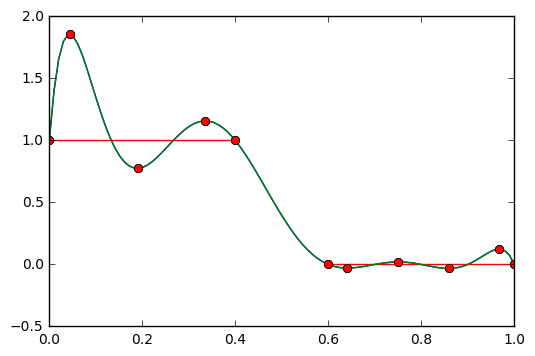

In [6]:
A = 0.4
B = 0.6
p, x, y = MSE_fit(A, B, 8)

loc, err = find_error_extrema(p, 0.4, 0.6)

t = np.linspace(0, 1, 100)
plt.plot(loc, p(loc), 'or', t, p(t), '-')
plt.plot((0,A), (1,1), 'red', 
         (B,1), (0,0), 'red',  
         t, p(t), '-',
         loc, p(loc), 'or');

### The Remez Exchange Algorithm

The alternation theorem provides us also with a very efficient way to find the coefficients of $P(x)$. Suppose we knew the exact ordinates $x_i$ of the $M+2$ alternations; in this case we could solve the following system of linear equations

$$
    \left\{\begin{array}{lcl}
        p_0 + p_1 x_0 + p_2 x_0^2 + \ldots + p_Mx_0^M + (-1)^0\epsilon &=& D(x_0) \\ 
        p_0 + p_1 x_1 + p_2 x_1^2 + \ldots + p_Mx_1^M + (-1)^1\epsilon &=& D(x_1) \\ 
        \ldots \\ 
        p_0 + p_1 x_{M+1} + p_2 x_{M+1}^2 + \ldots + p_Mx_{M+1}^M + (-1)^{M+1}\epsilon &=& D(x_{M+1}) 
      \end{array}\right.
$$

and find in one go both the $M+1$ polynomial coefficients *and* the value of the minimax error $E=|\epsilon|$ (we use $\epsilon$ instead of $E$ in the linear system because we don't know the sign of the first alternation, it could be positive or negative). Although the above is a non-standard linear system of equations, it can be shown rather easily that, as long as the $x_i$ are distinct, it does have a solution. 

Of course we don't know the $x_i$ in advance but we can start with a guess, and solve the system anyway. Once we find the polynomial coefficients from the guess, we use Remez's exchange algorithm:

* find the locations for the maxima and minima of the error for the $P(x)$ we just found
* if the extrema satisfy the alternation theorem, we are done
* otherwise, use the new locations as a new guess, solve the system again and repeat.



The Remez algorithm is remarkably fast and robust. Here is an implementation you can play with. First, we need an auxiliary function to solve the system of equations above; we will use standard linear algebra functions.

In [7]:
def solve(x, y):
    # simple solver for the extended interpolation problem
    # first build a Vandermonde matrix using the interpolation locations
    # There are N+2 locations, so the matrix will be (N+2)x(N+2) but we 
    #  will replace the last column with the error sign
    V = np.vander(x, increasing=True)
    # replace last column
    V[:,-1] = pow(-1, np.arange(0, len(x)))
    # just solve Ax = y
    v = np.linalg.solve(V, y)
    # need to reverse the vector because poly1d starts with the highest degree
    p = np.poly1d(v[-2::-1])
    e = np.abs(v[-1])
    return p, e

And here comes the main course: the Remez routine. The code is quite straightforward; it doesn't have a termination conditions since the number of iterations is passed as a parameter (we want to be able to show intermediate results).

In [8]:
def remez_fit(A, B, order, iterations):
    if order < 3:
        raise ValueError("order is too small, we need at least 3")
    pts = order+2
    
    # initial choice of interpolation points: distribute them evenly
    #  across the two regions as a proportion of each region's width
    ptsA = int(pts * A / (A-B+1))
    if ptsA < 2:
        ptsA = 2
    ptsB = pts - ptsA
    
    x = np.concatenate((
        np.arange(1, ptsA+1) * (A / (ptsA+1)),
        B + np.arange(1, ptsB+1) * ((1-B) / (ptsB+1))            
        ))
    y = np.concatenate((
        np.ones(ptsA),
        np.zeros(ptsB)            
        ))
    
    # the "data" dictionary only holds values that we will use in plotting
    data = {}
    
    for n in range(0, iterations):
        # previous interpolation points
        data['prev_x'] = x
        data['prev_y'] = y
        
        # solve the interpolation problem 
        p, e = solve(x, y)
        data['err'] = e
        # find the extrema of the error
        loc, err = find_error_extrema(p, A, B) 
        
        # find the alternations 
        alt = []
        for n in range(0, len(loc)):
            # each extremum is a new candidate for an alternation
            c = {
                'loc': loc[n],
                'sign': np.sign(err[n]),
                'err_mag': np.abs(err[n])
            }
            # only keep extrema that are larger or equal than the minimum
            #  error returned by the interpolation solution
            if c['err_mag'] >= e - 1e-3:
                # ensure that the error alternates; if the candidate has the  
                #  same sign, replace the last alternation with the candidate
                #  if its error value is larger
                if alt == [] or alt[-1]['sign'] != c['sign']:
                    alt.append(c)
                elif alt[-1]['err_mag'] < c['err_mag']:
                    alt.pop()
                    alt.append(c)
        
        # if there are more than the necessary number of alternations, trim 
        #  from the left or the right keeping the largest errors
        while len(alt) > order + 2:
            if alt[0]['err_mag'] > alt[-1]['err_mag']:
                alt.pop(-1)
            else:
                alt.pop(0)
        
        # the new set of interpolation points
        x = [c['loc'] for c in alt]
        y = [1 if c <= A else 0 for c in x]
        data['new_x'] = x

    return p, data

Finally, a simple auxiliary function to plot the results; the yellow dots indicate the guess used for the current interpolation while the blue stars show the new maxima that will be used as the new guess. As you can see the algorithm converges very rapidly. The error in passband and stopband is shown magnified in the bottom panels.

In [9]:
def remez_fit_show(A=0.4, B=0.6, order=5, iterations=1):
    p, data = remez_fit(A, B, order, iterations)
    
    def loc_plot(A, B, data):    
        e = data['err']
        plt.plot((0,A), (1,1), 'red',
                 (B,1), (0,0), 'red', 
                 (0,A), (1+e,1+e), 'cyan', (0,A), (1-e,1-e), 'cyan',
                 (B,1), (e,e), 'cyan', (B,1), (-e,-e), 'cyan',
                 data['prev_x'], data['prev_y'], 'oy', 
                 data['new_x'], p(data['new_x']), '*',
                 t, p(np.linspace(0, 1, 100)), '-')  
    
    loc_plot(A, B, data)
    plt.show()
    
    e = 1.5 * data['err']
    lims = [(0, A , 1-e, 1+e), (B, 1, -e, e)]
    for n, r in enumerate(lims):
        plt.subplot(1,2,n+1)
        loc_plot(A, B, data)
        plt.xlim(r[0], r[1])
        plt.ylim(r[2], r[3]) 

In [10]:
v = interactive(remez_fit_show, A=(0.0, 0.5, 0.4), B=(0.5, 1.0), order=(3,12), iterations=(1, 10))
display(v)

interactive(children=(FloatSlider(value=0.4, description=u'A', max=0.5, step=0.4), FloatSlider(value=0.6, description=u'B', max=1.0, min=0.5), IntSlider(value=5, description=u'order', max=12, min=3), IntSlider(value=1, description=u'iterations', max=10, min=1), Output()), _dom_classes=('widget-interact',))

## Weighting the error

In the example above we used a very simple piecewise constant target function $D(x)$ but the Alternation Theorem is actually much more general and the Remez algorithm can be used to approximate more complicated characteristics. 

In particular, a *weighting function* can be used in the minimax problem formulation in order to tune the error in the approximation regions. Think of minimax filter design as a budgeting problem: for a given number of coefficients, we need to make sure that the bandpass and bandstop reqirements are fulfilled first, while the error is a consequence of the budget. With a weighting function we can decide to allocate a larger part of the budget to either passband or stopband. 

Mathematically, the minimax problem becomes:

$$
    E = \min\max_{[0,A]\cup [B,1]} | W(x)[P(x) - D(x)] |
$$

but the alternation theorem still holds:

> $P(x)$ is the minimax approximation to $D(x)$ *weighted by $W(x)$* if and only if $W(x)[P(x) - D(x)]$ alternates $M+2$ times between $+E$ and $-E$ over $[0,A]\cup [B,1]$

For instance, suppose we want the error in the first interval to be 10 times smaller than in the second interval. In this case the weighting function will be equal to 0.1 over $[0,A]$ and just one over $[B,1]$. We can rewrite the extended interpolation problem as

$$
    \left\{\begin{array}{lcl}
        p_0 + p_1 x_0 + p_2 x_0^2 + \ldots + p_Mx_0^M + (-1)^0\epsilon/10 &=& 1 \\ 
        p_0 + p_1 x_1 + p_2 x_1^2 + \ldots + p_Mx_1^M + (-1)^1\epsilon/10 &=& 1 \\ 
        \ldots \\ 
        p_0 + p_1 x_{M} + p_2 x_{M}^2 + \ldots + p_Mx_{M}^M + (-1)^{M}\epsilon &=& 0\\ 
        p_0 + p_1 x_{M+1} + p_2 x_{M+1}^2 + \ldots + p_Mx_{M+1}^M + (-1)^{M+1}\epsilon &=& 0 
      \end{array}\right.
$$

The following code is a simple modification of the algorithm detailed above to include error weighting:



In [11]:
def remez_fit2(A, B, Aweight, order, iterations):
    def weigh(x):
        # the weighting function
        if np.isscalar(x):
            return 1.0/Aweight if x <= A else 1
        else:
            return [1.0/Aweight if v <= A else 1 for v in x]
        
    pts = order+2
    ptsA = int(pts * A / (A-B+1))
    if ptsA < 2:
        ptsA = 2
    ptsB = pts - ptsA
    x = np.concatenate((
        np.arange(1, ptsA+1) * (A / (ptsA+1)),
        B + np.arange(1, ptsB+1) * ((1-B) / (ptsB+1))            
        ))
    y = np.concatenate((
        np.ones(ptsA),
        np.zeros(ptsB)            
        ))
    
    data = {}    
    for n in range(0, iterations):
        data['prev_x'] = x
        data['prev_y'] = y
        
        # solve the interpolation problem with weighted error
        V = np.vander(x, increasing=True)
        V[:,-1] = pow(-1, np.arange(0, len(x))) * weigh(x)
        v = np.linalg.solve(V, y)
        p = np.poly1d(v[-2::-1])
        e = np.abs(v[-1])
        data['Aerr'] = e / Aweight
        data['Berr'] = e
        
        loc, err = find_error_extrema(p, A, B) 
        alt = []
        for n in range(0, len(loc)):
            c = {
                'loc': loc[n],
                'sign': np.sign(err[n]),
                'err_mag': np.abs(err[n]) / weigh(loc[n])
            }
            if c['err_mag'] >= e - 1e-3:
                if alt == [] or alt[-1]['sign'] != c['sign']:
                    alt.append(c)
                elif alt[-1]['err_mag'] < c['err_mag']:
                    alt.pop()
                    alt.append(c)
        while len(alt) > order + 2:
            if alt[0]['err_mag'] > alt[-1]['err_mag']:
                alt.pop(-1)
            else:
                alt.pop(0)
        
        x = [c['loc'] for c in alt]
        y = [1 if c <= A else 0 for c in x]
        data['new_x'] = x

    return p, data

In [12]:
def remez_fit_show2(A=0.4, B=0.6, Aweight=50, order=10, iterations=1):
    p, data = remez_fit2(A, B, Aweight, order, iterations)
    
    t = np.linspace(0, 1, 300)
    Ae = data['Aerr']
    Be = data['Berr']
    
    def loc_plot(A, B, data):  
        plt.plot((0,A), (1,1), 'red',
                 (B,1), (0,0), 'red', 
                 (0,A), (1+Ae,1+Ae), 'cyan', (0,A), (1-Ae,1-Ae), 'cyan',
                 (B,1), (Be,Be), 'cyan', (B,1), (-Be,-Be), 'cyan',
                 data['prev_x'], data['prev_y'], 'oy', 
                 data['new_x'], p(data['new_x']), '*',
                 t, p(t), '-')  
    
    loc_plot(A, B, data)
    plt.show()
    
    lims = [(0, A , 1-1.5*Ae, 1+1.5*Ae), (B, 1, -1.5*Be, 1.5*Be)]
    for n, r in enumerate(lims):
        plt.subplot(1,2,n+1)
        loc_plot(A, B, data)
        plt.xlim(r[0], r[1])
        plt.ylim(r[2], r[3]) 
        
        
        
v = interactive(remez_fit_show2, 
                A=(0.0, 0.5, 0.4), B=(0.5, 1.0), 
                Aweight=(1,100,10),
                order=(5,20), 
                iterations=(1, 10))
display(v)

interactive(children=(FloatSlider(value=0.4, description=u'A', max=0.5, step=0.4), FloatSlider(value=0.6, description=u'B', max=1.0, min=0.5), IntSlider(value=50, description=u'Aweight', min=1, step=10), IntSlider(value=10, description=u'order', max=20, min=5), IntSlider(value=1, description=u'iterations', max=10, min=1), Output()), _dom_classes=('widget-interact',))